# Direct elicitation in 1D

In [1]:

import preliz as pz

In [2]:
pz.style.library["preliz-doc"]["figure.dpi"] = 100
pz.style.library["preliz-doc"]["figure.figsize"] = (10, 4)
pz.style.use("preliz-doc")

(distributions_interactive)=

## Distributions

When setting priors for a Bayesian model, sometimes all we need is to quickly inspect the shape of a distribution. We usually want to identify where the bulk of the mass is, or how thick the tails are. Even if we are familiar with a given family, getting the right parameters may require to change them a few times, until we get something close to what we have in mind.

With PreliZ we can easily plot the [probability density function](https://en.wikipedia.org/wiki/Probability_density_function) (pdf) of a given distribution.

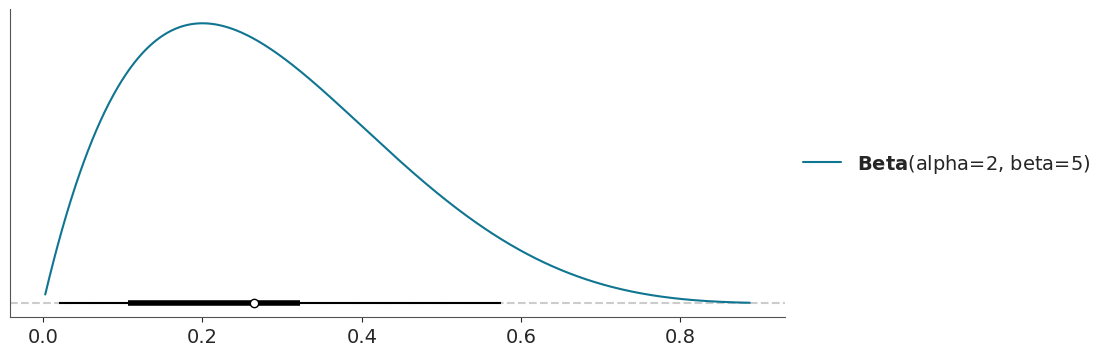

In [3]:
pz.Beta(2, 5).plot_pdf(pointinterval=True);

We got the PDF in blue, and because we passed the argument `pointinterval=True` we also got a box-plot-like element at the bottom, that may help us interpret what a `Beta(2, 5)` actually means. The white dot represents the median, the thicker line the interquartile range, i.e the interval defined by the quantiles 0.25 and 0.75 (or in other words the central 50% of the distribution) and the thinner line the interval defined by the 0.05 and 0.95 quantiles.

For simplicity we also use `plot_pdf` (instead of plot_pmf) for discrete distributions

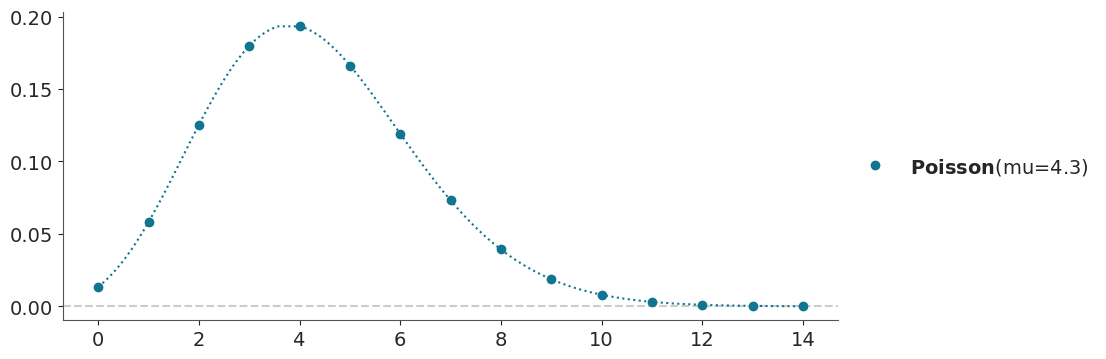

In [4]:
pz.Poisson(4.3).plot_pdf();

We can include more than one distribution in the same plot. This can be useful to compare the impact of parameters on a given distribution or even different distributions.

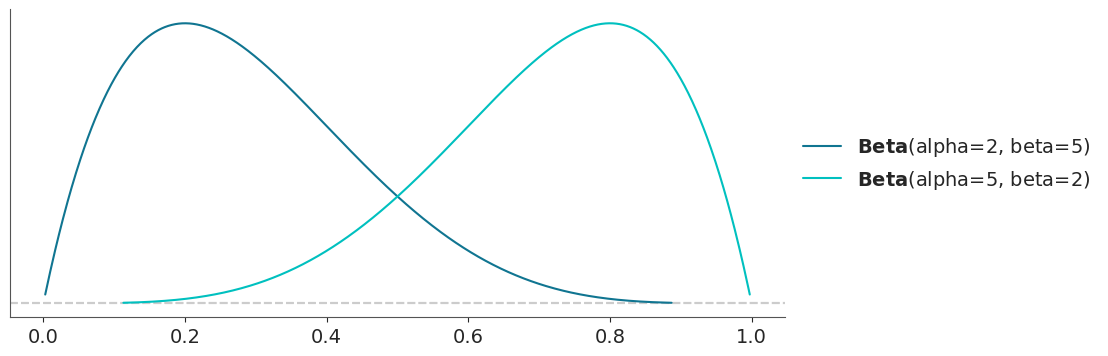

In [5]:
pz.Beta(2, 5).plot_pdf()
pz.Beta(5, 2).plot_pdf();

We can also easily plot the [cumulative distribution function](https://en.wikipedia.org/wiki/cumulative_distribution_function) (cdf).

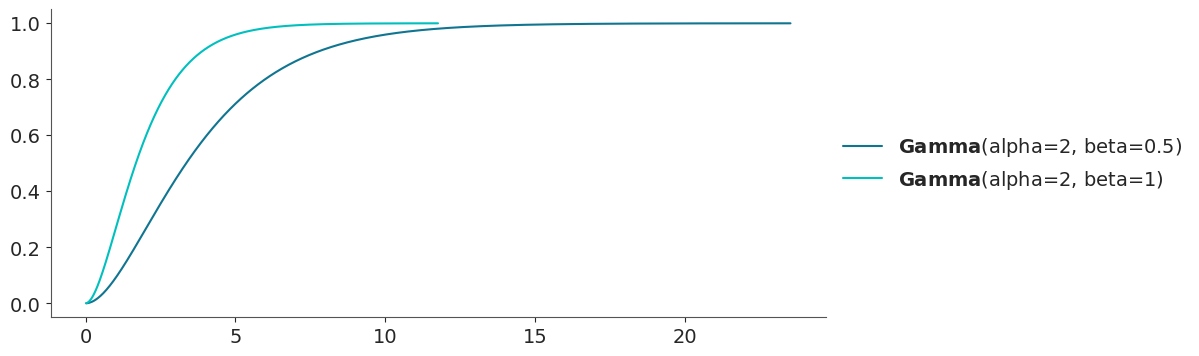

In [6]:
pz.Gamma(2, 0.5).plot_cdf()
pz.Gamma(2, 1).plot_cdf();

or the [quantile function](https://en.wikipedia.org/wiki/Quantile_function), also known as the percentile function or the inverse of the cdf.

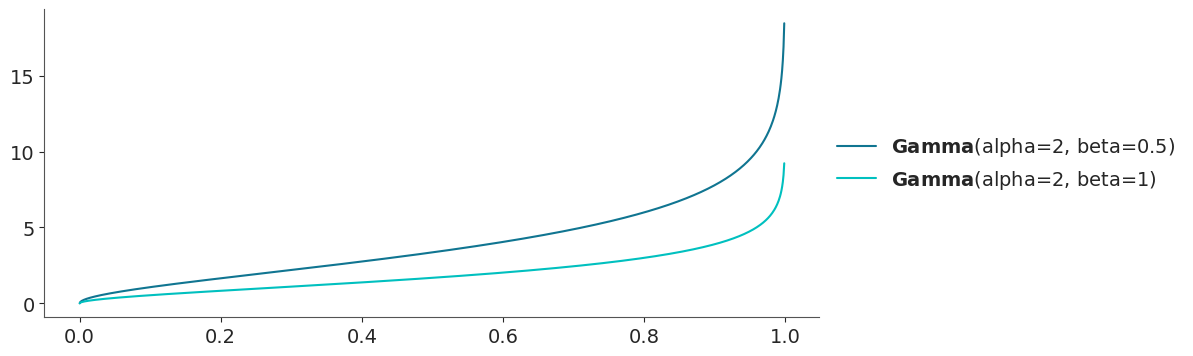

In [7]:
pz.Gamma(2, 0.5).plot_ppf()
pz.Gamma(2, 1).plot_ppf();

PreliZ also allows to interact with distributions using sliders.

In [8]:
pz.Gamma(mu=2, sigma=1).plot_interactive()

interactive(children=(FloatSlider(value=2.0, description='mu (0, inf)', max=12.0, min=2.220446049250313e-16, s…

As a general rule PreliZ distributions do not have default values for their parameters. Nevertheless, for the `plot_interactive()` method PreliZ provides a default initialization, which can be handy if we are not very familiar with the parameters a distribution can take.

In [9]:
pz.Gamma().plot_interactive()

interactive(children=(FloatSlider(value=2.0, description='alpha (0, inf)', max=12.0, min=2.220446049250313e-16…

The slider will conform to the bounds of the parameters, for instance the `alpha` parameter of the Gamma distribution is restricted to be positive. So the slider for alpha will also be restricted to positive values. Because there is no upper bound, PreliZ will pick one for you, if you want to try with higher values of the parameter just initialize the distribution at higher values, like 

```python
pz.Gamma(alpha=50, beta=1).plot_interactive()
```

### Alternative parametrization

Some of the distributions in PreliZ can be defined in more that one way. We have already seen that for the Gamma we can use `mu` (mean) and `sigma` (standard deviation), or `alpha` (shape) and `beta` (rate).


### Properties of distributions

Once we have set the parameters of a distribution we can obtain a few of its properties. The `summary` method, returns the mean, median, standard deviation and lower and upper values for the equal-tailed interval.

In [10]:
dist = pz.Beta(2, 5)
dist.summary()

Beta(mean=0.29, median=0.26, std=0.16, lower=0.02, upper=0.57)

Additionally, we can compute two different types of intervals out-of-the-box, the equal-tailed interval and the highest density interval. Following ArviZ, the default mass for these intervals is 0.94.

In [11]:
dist.eti(), dist.hdi()

((0.04768709037709384, 0.6266029713677336),
 (0.020466941017054388, 0.5744295071287167))

We can also ask for random samples

In [12]:
dist.rvs(10)

array([0.21403748, 0.15730695, 0.19358026, 0.23911927, 0.49014885,
       0.3188014 , 0.3889162 , 0.19003055, 0.53535661, 0.04141949])

or compute the quantiles

In [13]:
dist.ppf([0.1, 0.5, 0.9])

array([0.09259526, 0.26444998, 0.51031631])

We can compute the logarithm of the probability density function by doing:

In [14]:
dist.logpdf(0.5)

-0.06453852113757241

(maxent_interactive)=

## From intervals to maximum entropy distributions

Sometimes the best route to obtain a useful prior is not by tweaking the parameters of a given distribution. Instead, we may want a distribution to satisfy certain constraints. `pz.maxent` will find the distribution with maximum entropy that have a certain mass inside a given interval. Having priors with maximum entropy makes sense as this guarantees that we have the less informative distribution, given a set of constraints. 

Here we compare a Beta and a Normal, with the constraints of having 0.6 of the probability mass inside the interval [0.3-0.8].

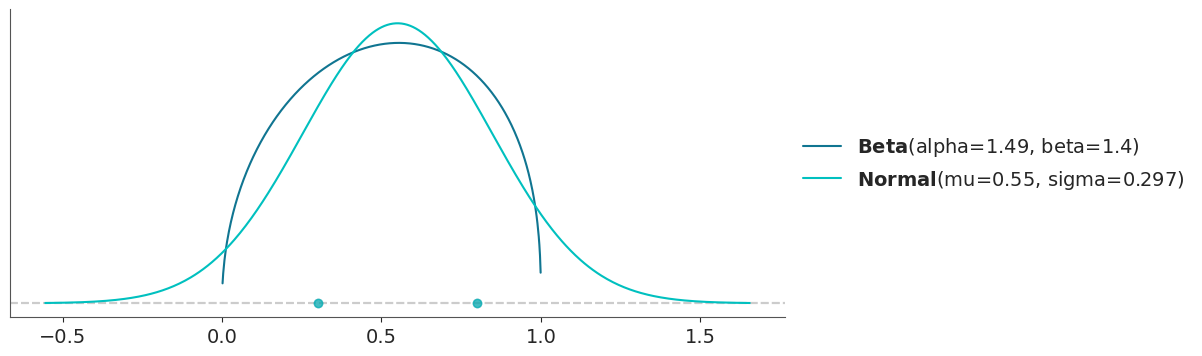

In [15]:
pz.maxent(pz.Beta(), 0.3, 0.8, 0.6)
pz.maxent(pz.Normal(), 0.3, 0.8, 0.6);

We can also keep some of the parameters fixed by directly passing their values to the distribution. For instance we may want to find a Gamma distribution with mean 4 and with 90% of the mass between 1 and 10.

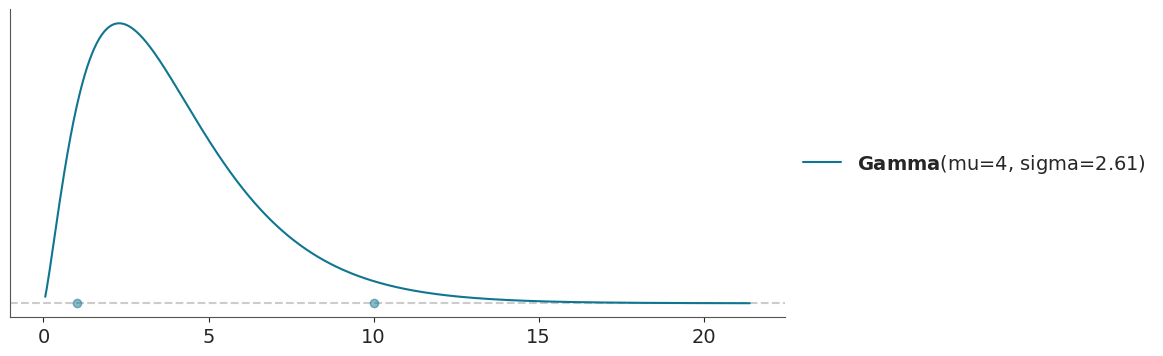

In [16]:
pz.maxent(pz.Gamma(mu=4), 1, 10, 0.9);

`maxent` update the distribution in place so if we do:

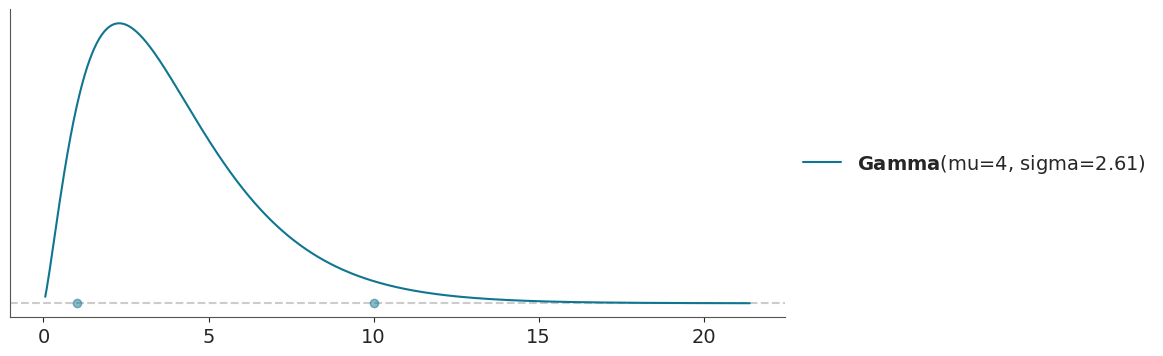

In [17]:
dist = pz.Gamma(mu=4)
pz.maxent(dist, 1, 10, 0.9);

we can then keep working with `dist`, for instance to get its parameters

In [18]:
dist.alpha, dist.beta

(2.341680163267631, 0.5854200408169078)

`maxent` (and other optimization functions we will see later) returns and [OptimizeResult](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html#scipy.optimize.OptimizeResult) that users can inspect if they need more information of the result of the optimization routine.

In [19]:
_, opt = pz.maxent(pz.Normal(), -1, 1, 0.68, plot=False)
opt

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.4244960108798204
       x: [-1.330e-08  1.006e+00]
     nit: 4
     jac: [ 0.000e+00 -9.945e-01]
    nfev: 12
    njev: 4

(quartile_interactive)=

## From intervals and quartiles to distributions

One alternative to `maxent` is to define a distribution by its [quartiles](https://en.wikipedia.org/wiki/Quartile), that is by the 3 points which divides the distribution into 4 parts each with 25% of the total mass.

The expected masses are 0.25, 0.5, 0.75
 The computed ones are: 0.29, 0.44, 0.77


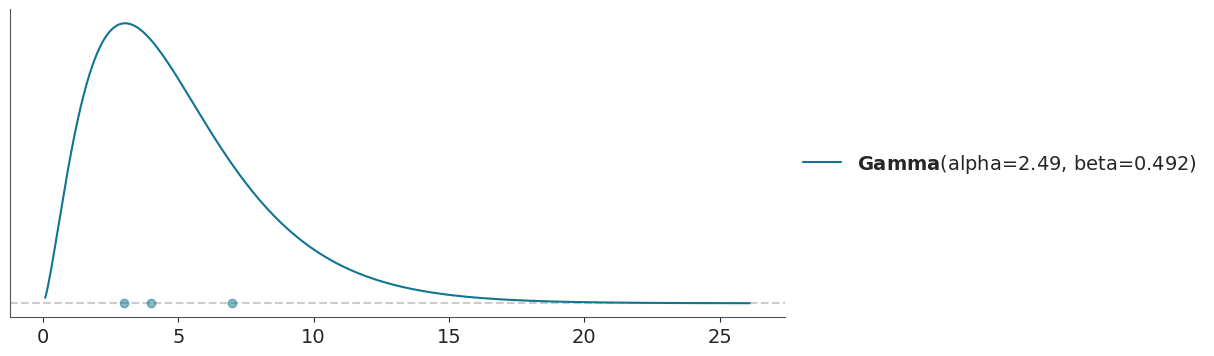

In [20]:
pz.quartile(pz.Gamma(), 3, 4, 7);

You can use `pz.quartile_int` to specify a list of distribution names to be used in the elicitation.

Both `pz.quartile` and `pz.maxent` will return a message when the difference between the requested and computed masses is larger than certain threshold.

(mle_interactive)=

## From samples to maximum likelihood distributions

Yet another scenario is to have some data that we want to use as a prior. One way to do it is to fit the data to some parametric family of distributions. We can then use a maximum likelihood estimate to get the distribution with the best fit. To rank the distributions we use the Akaike Criterion, which includes a [penalization term](https://en.wikipedia.org/wiki/Akaike_information_criterion#Modification_for_small_sample_size) related to the number of parameters of each distribution.

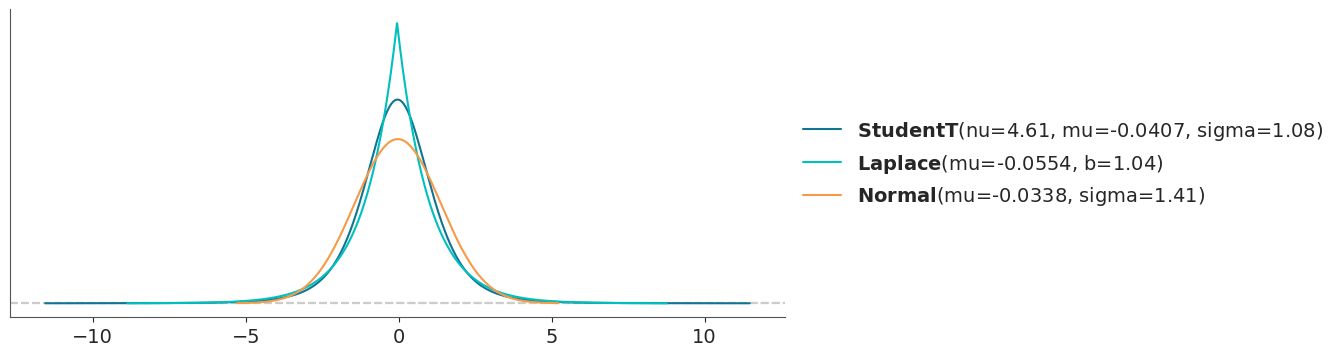

In [21]:
# In a real scenario this will be some data and not a sample from a PreliZ distribution
sample = pz.StudentT(4, 0, 1).rvs(1000) 

dist0 = pz.StudentT()
dist1 = pz.Normal()
dist2 = pz.Laplace()
pz.mle([dist0, dist1, dist2], sample, plot=3);  # we ask to plot all 3 distributions

By default `pz.mle` only plots the best match, but here we decided to get a plot of the 3 of them. Notice that the distributions are updated in place so we can get access to them.

In [22]:
dist0

StudentT(nu=4.61, mu=-0.0407, sigma=1.08)

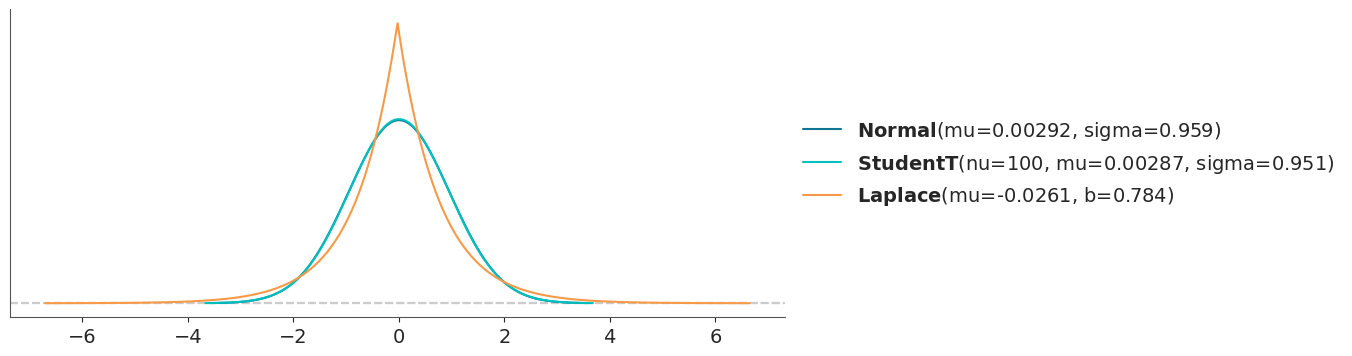

In [23]:
# In a real scenario this will be some data and not a sample from a PreliZ distribution
sample = pz.StudentT(5000, 0, 1).rvs(1000) 

dist0 = pz.StudentT()
dist1 = pz.Normal()
dist2 = pz.Laplace()
pz.mle([dist0, dist1, dist2], sample, plot=3);  # we ask to plot all 3 distribution

(roulette_interactive)=

## The roulette method

The roulette method allows us to find a prior distribution by *drawing*. The name roulette comes from the analogy that we are placing a limited set of chips where we think the mass of a distribution should be.

For this task we are offered with a grid of m equally sized bins covering the range of x. And we have to allocate a total of n chips between the bins. In other words we use a grid to draw a histogram and the function will try to tell us what distribution, from a given pool of options, is a better fit for our drawing.

The `pz.roulette()` function uses matplotlib interactively, for this to work we need to call the magic `%matplotlib widget` and have ipywidgets installed (a requirement of PreliZ).

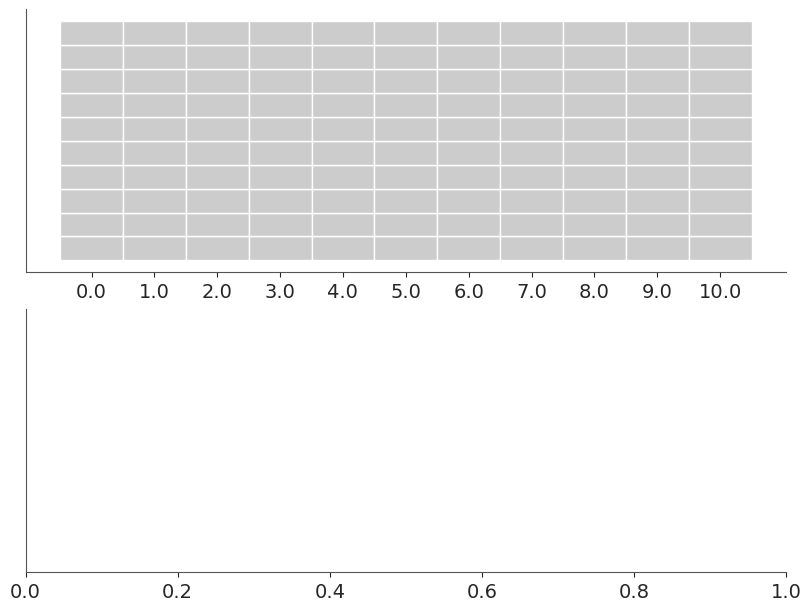

In [24]:
%matplotlib widget
pz.roulette()

If you are unable to run the previous cell, you can get a glimpse of `roulette` from this gif

![roulette](roulette.gif)

(quartile_int_interactive)=

## The quartile_int method

The quartile_int method allows us to perform prior elicitation for 1D distributions from quartiles.

We can pass values for the quartiles, and the function will return the closest 1D distribution to that input. We can select one or more distributions from a menu by clicking or by passing a list of strings when calling the function. Additionally, we can optionally parameterize distributions. This is useful, for example, to set 'nu' for `pz.StudentT` or boundaries for distributions such as `pz.TruncatedNormal` and `pz.BetaScaled`.

Similar to `pz.roulette()`, `the pz.quartile_int()` function utilizes matplotlib interactively. For this to function properly, it is necessary to invoke the magic command `%matplotlib widget` and ensure that ipywidgets is installed, as it is a requirement for PreliZ.

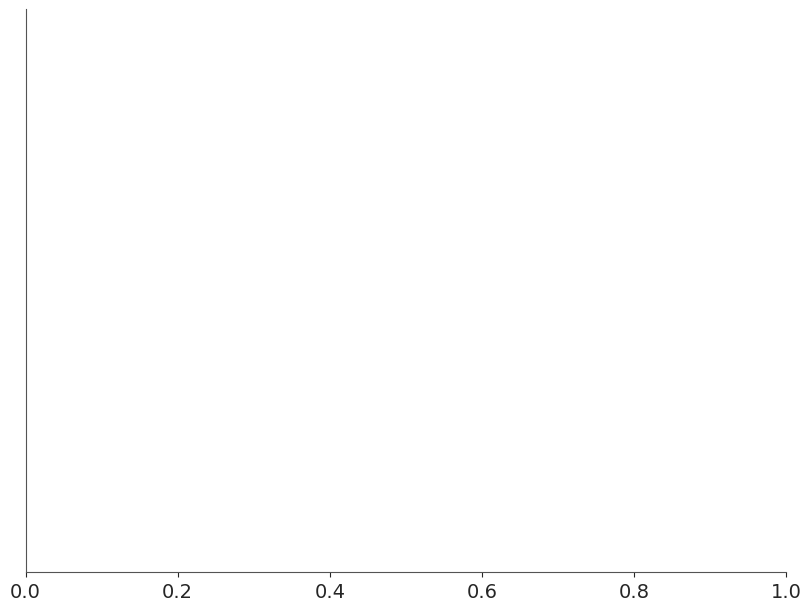

In [25]:
%matplotlib widget
pz.quartile_int(1, 2, 3, ["StudentT", "TruncatedNormal", "BetaScaled"], None)

If you are unable to run the previous cell, you can get a glimpse of `quartile_int` from this gif

![quartile_int](quartile_int.gif)